https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import Xception, MobileNetV2, ResNet50, InceptionV3
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2, zipfile, shutil, os, glob

## 1) 경로설정

In [11]:
os.getcwd()

'C:\\workspace\\study_folder\\project\\chest_cancer\\Analysis'

In [73]:
root_dir = 'C:\\workspace\\study_folder\\project\\chest_cancer'
data_root = os.path.join(root_dir, 'Data')
train_data_root = os.path.join(data_root, 'train')
test_data_root = os.path.join(data_root, 'test')
val_data_root = os.path.join(data_root, 'valid')

## 2) 데이터 가져오기

In [88]:
# 디렉토리 내부의 data zip파일 추충
# with zipfile.ZipFile(os.path.join(root_dir, 'chest_cancer.zip')) as target_file:
#    target_file.extractall(root_dir)

In [89]:
# train, test, val 폴더 내부의 분류이름 확인하기
print(os.listdir(train_data_root))
print("---------------------------------------")
print(os.listdir(test_data_root))
print("---------------------------------------")
print(os.listdir(val_data_root))

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
---------------------------------------
['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
---------------------------------------
['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [90]:
# test 폴더 내부의 분류 이름으로 나머지 train, val 폴더 내부 이름 통일하기
class_name_list = os.listdir(test_data_root)
train_change_name_list = os.listdir(train_data_root)
val_change_name_list = os.listdir(val_data_root)

for i in range(len(train_change_name_list)) :
    # train 폴더 내부 폴더이름변경
    os.rename(os.path.join(train_data_root, train_change_name_list[i]), os.path.join(train_data_root, class_name_list[i]))
    # val 폴더 내부 폴더이름변경
    os.rename(os.path.join(val_data_root, val_change_name_list[i]), os.path.join(val_data_root, class_name_list[i]))


In [100]:
# train, test, val 파일 갯수 확인
test_label_list = os.listdir(test_data_root)
train_label_list = os.listdir(train_data_root)
val_label_list = os.listdir(val_data_root)

print('train 폴더 갯수')
for label_name in train_label_list:
    print('train label : ', label_name, "=>", 
    len(os.listdir(os.path.join(train_data_root, label_name))))
print("==============================================")

print('test 폴더 갯수')
for label_name in test_label_list:
    print('train label : ', label_name, "=>", 
    len(os.listdir(os.path.join(test_data_root, label_name))))
print("==============================================")

print('val 폴더 갯수')
for label_name in val_label_list:
    print('val label : ', label_name, "=>", 
    len(os.listdir(os.path.join(val_data_root, label_name))))
print("==============================================")

train 폴더 갯수
train label :  adenocarcinoma => 195
train label :  large.cell.carcinoma => 115
train label :  normal => 148
train label :  squamous.cell.carcinoma => 155
test 폴더 갯수
train label :  adenocarcinoma => 120
train label :  large.cell.carcinoma => 51
train label :  normal => 54
train label :  squamous.cell.carcinoma => 90
val 폴더 갯수
val label :  adenocarcinoma => 23
val label :  large.cell.carcinoma => 21
val label :  normal => 13
val label :  squamous.cell.carcinoma => 15


## 3) 이미지 확인

In [101]:
# 이미지 shape 설정
img_width = 100
img_height = 100

In [113]:
# imagedatagenerator이용한 데이터 불러오기(부족한 이미지 데이터 불리기)
train_data_gen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)
val_data_gen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)

In [118]:
train_gen = train_data_gen.flow_from_directory(directory=train_data_root,
                                  batch_size=32,
                                  target_size = (img_height, img_width),
                                  class_mode = 'sparse',
                                  color_mode = 'rgb',
                                  subset = 'training')

val_gen = val_data_gen.flow_from_directory(directory=val_data_root,
                                  batch_size=32,
                                  target_size = (img_height, img_width),
                                  class_mode = 'sparse',
                                  color_mode = 'rgb')

test_gen = test_data_gen.flow_from_directory(directory=test_data_root,
                                  batch_size=32,
                                  target_size = (img_height, img_width),
                                  class_mode = 'sparse',
                                  color_mode = 'rgb')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [120]:
print(train_gen.class_indices)
print(train_gen.class_mode)

{'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
sparse


In [131]:
data, label = train_gen.next()

data = data[:9]
label = label[:9]

print(data.shape, label.shape)
print(label)

(9, 100, 100, 3) (9,)
[2. 1. 0. 0. 1. 1. 1. 2. 2.]


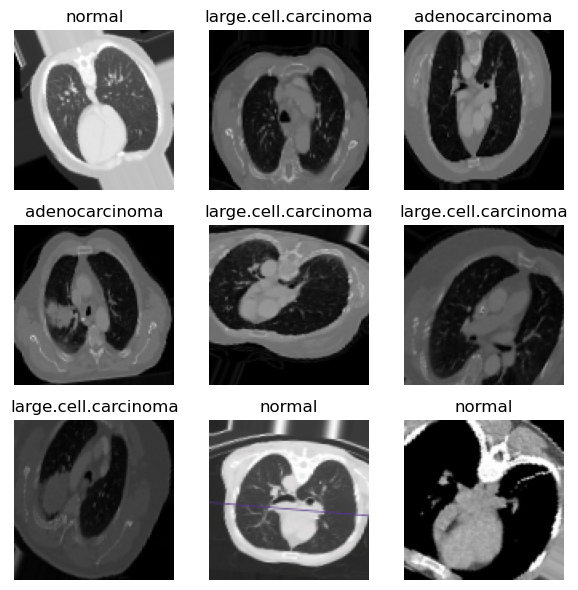

In [132]:
plt.figure(figsize = (6,6))
class_dict = {0 : 'adenocarcinoma', 1 : 'large.cell.carcinoma', 2 : 'normal', 3 : 'squamous.cell.carcinoma'}
for i in range(len(label)):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

## 4) 모델 구축
-  Xception, MobileNetV2, ResNet50, InceptionV3

### (1) Xception

In [133]:
base_model = Xception(weights='imagenet', include_top = False,
                     input_shape=(img_width, img_height, 3))
base_model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 49, 49, 32)           864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 49, 49, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [135]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21069740 (80.37 MB)
Non-trainable params: 54528 (213.00 KB)
________

In [136]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])